# Lesson 12 - Introduction to NLP

> Introduction to Natural Language Processing (NLP).

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/dslectures/master?urlpath=lab/tree/notebooks%2Flesson12_nlp-intro.ipynb) [![slides](https://img.shields.io/static/v1?label=slides&message=lesson12_nlp-intro.pdf&color=blue&logo=Google-drive)](https://drive.google.com/open?id=11m5iXGNJEUlvjSMLdQAztJyVZ2LLj4oz)

## Learning objectives
In this lecture we cover the basics of NLP to build a sentiment classifier in scikit-learn. The learning goals are:
* Know the basics of string processing in python
* Preprocessing steps in NLP
* Count and TF-IDF encodings
* Naïve Bayes classifier

## References
* Chapter 10: Representing and Mining Text in _Data Science for Business_ by F. Provost and P. Fawcett

## Homework
As homework read the references, work carefully through the notebook and solve the exercises. 

## Introduction to NLP

<div style="text-align: center">
<img src='images/natural-language-processing-so-hot-right-now.jpg' width='400'>
</div>

Natural language processing (NLP) concerns the part of Machine Learning about the analysis of digital, human written texts. The topic of NLP is as old as machine learning itself and dates back to Alan Turing himself. Since text is a widely used medium there are plenty of applications of machine learning:

- Text classification
- Question/answering systems
- Dialogue systems
- Named entity recognition
- Summarization
- Text generation

Especially in the past few years there has been exciting and rapid progress in the field. One example is the release of OpenAI's GPT-2, a language model able to not only create realistic text samples but also solve tasks of many NLP benchmarks without special training. See the figure below for an example output of GPT-2.

If you want to try your own examples you can do so at [talktotransformer.com](https://talktotransformer.com/) or read the original article on [OpenAI's webpage](https://openai.com/blog/better-language-models/).

<div style="text-align: center">
<img src='images/gpt2-example.png' width='400'>
</div>
    
Natural text is different to other data sources such as numerical tables or images. One way to look at text is to consider each word to be a feature. Since most languages have of the order of 100k words in their vocabulary plus many variations this leads to an enormous feature space. At the same time most words in the vocabulary do not appear in a small text. This leads to extreme sparsity. These properties call for a different approach to NLP than the methods we encountered and used for tabular data.

## Notebook overview
The goal of this notebook is to classify movie reviews in terms of positive or negative feedback. This task is called sentiment analysis and is a common NLP application. As a company you might use a sentiment classifier to analyse customer feedback or detect toxic comments on your website.

<div style="text-align: center">
<img src='images/sentiment-meme.jpg' width='400'>
</div>

Text data can be messy and require some clean up. The specific steps for the clean-up can depend on how the data was generated or where it was found. Text from the web might have some html artifacts that need cleaning or product reviews could include meta information on the review. Python offers powerful tools to manipulate strings. If cleaning requires complex rules one can also resort to regular expressions or regex for short.

Once the text is cleaned we have to encode it in a way that machine learning methods can handle. Directly using text representation as input is not possible. Most machine learning methods can only handle numerical data such as vectors and matrices. So we have to encode the input texts as vectors or matrices. These text representations are called vector encodings. Furthermore, we look at n-grams to keep some of the sequential structure of text.

Finally, we can train a model to classify the movie review texts. However, the Random Forest models we already know well do not work well for the high-dimensional data. We introduce a new methods that is common for text data called the Naïve Bayes classifier that utilises Bayes theorem.



## Imports

In [ ]:
import pandas as pd
import numpy as np
import pickle

import warnings
warnings.filterwarnings("ignore")

from dslectures.core import get_dataset

from tqdm import tqdm
tqdm.pandas(desc="progress")

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

## Part 1: Dataset

First, we load the IMDB dataset as a dataframe. Note that this is not the original dataset from [here](https://ai.stanford.edu/~amaas/data/sentiment/), but a version that I pre-processed for the ease of use.

In [ ]:
get_dataset('imdb.csv')

Download of imdb.csv dataset complete.


In [ ]:
df_imdb = pd.read_csv('../data/imdb.csv')

In [ ]:
df_imdb.head()

,filename,text,sentiment,train_label
0,4715_9,For a movie that gets no respect there sure ar...,pos,train
1,12390_8,Bizarre horror movie filled with famous faces ...,pos,train
2,8329_7,"A solid, if unremarkable film. Matthau, as Ein...",pos,train
3,9063_8,It's a strange feeling to sit alone in a theat...,pos,train
4,3092_10,"You probably all already know this by now, but...",pos,train


The dataset consists of a `filename`, `text`, `sentiment` and a `train_label`. The latter splits the data into a train and test set which is used as the official benchmark. We will follow that same split. 

But first we want to make the `sentiment` column categorical:

In [ ]:
df_imdb['sentiment'] = df_imdb['sentiment'].astype('category')

Now, let's have a look at a few text examples. For that purpose we wrote a helper function to print examples from the dataset:

In [ ]:
def print_n_samples(df, n):
    """
    Helper function to print data samples from IMDB dataset.
    """
    for i in range(n):
        print('SAMPLE', i+1, '\n')
        df_sample = df.sample(1)
        print(df_sample['text'].values[0])
        print('\nSentiment:', df_sample['sentiment'].values[0],'\n')
        print("".join(100*['=']))

We can show a few examples:

In [ ]:
print_n_samples(df_imdb, 2)

SAMPLE 1 

I have just seen Today You Die. It is bad, almost very bad.<br /><br />1) The direction and editing are awful, just awful. Almost made me turn off the movie, Fauntleroy (the director) has no idea what he is doing, he seems to be filming things at random and some scenes don't make sense at all. Also, I hate it when the same scene is used again in the same movie, in this movie some scenes were used 3 or 4 times. Pretty bad.<br /><br />2) The dialogue is sometimes good, sometimes awful. I like the fact that they wanted to make Seagal's character and Treach's character seem like they were in a similar relationship to the characters in Lethal Weapon, but it did not work simply because some of the dialogue DID NOT MAKE SENSE, and I speak English very well, it's not that I did not understand the words, it was the fact that the jokes and dialogue lines had no meaning whatsoever.<br /><br />3) The script is pretty bad. Why do they always try to complicate DTV action movies? Seagal's 

We can see that the reviews are medium sized texts with positive and negative labels.

### Exercise 1
A few exploratory and processing tasks:
* Create a plot with showing the distribution of positive and negative comments in the train and test dataset.
* Study the distribution of the text lengths. You can perform string operations on a `pandas.DataFrame` by accessing the `str` object of a column: `df['YOUR_TEXT_COLUMN'].str.len()`.

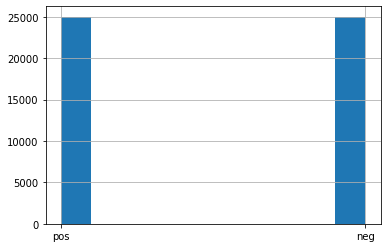

In [ ]:
df_imdb['sentiment'].hist()

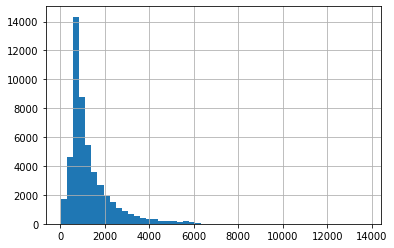

In [ ]:
df_imdb['text'].str.len().hist(bins=50)

## Part 2: Preprocessing

In this section we have a look at the basics of string processing. Being able to filter/combine/manipulate strings is a crucial skill to do natural language processing.

Cleaning up text for NLP tasks usually involves the following steps.
* Normalization
* Tokenization
* Remove stop-words
* Remove non-alphabetical tokens
* Stemming

Some of the steps might not be necessary or you need to add steps depending on the text, task and method. For our task these steps are fine. We apply these steps on one text as an example and then build a function to apply it to all texts.


### String processing in Python
Python offers powerful properties and functions to manipulate strings. The Python primer notebook offers an introduction to string processing with Python. Make sure to check it out. Once you are armed with this arsenal of string processing tools, we can preprocess the texts in the dataset to bring them to a cleaner form. Fortunately we don't need to implement everything from scratch. One of the richest Python libraries to process texts is the Natural Language Toolkit (NLTK) which offers some powerful functions we will use.

### Exercise 2
Work through the string processing introduction in the Python primer notebook.

### Input
We see that the raw text as several features such as capitalisation, special characters, numericals and puncuations. 

In [ ]:
text = df_imdb.loc[0, 'text']
print(text)

For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.


### Normalize
This is the process of transforming the text to lower-case.

In [ ]:
text = text.lower()
print(text)

for a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. imagine a movie where joe piscopo is actually funny! maureen stapleton is a scene stealer. the moroni character is an absolute scream. watch for alan "the skipper" hale jr. as a police sgt.


### Tokenize
Now we split the text in words/tokens.

In [ ]:
tokens = word_tokenize(text)
print(tokens)

['for', 'a', 'movie', 'that', 'gets', 'no', 'respect', 'there', 'sure', 'are', 'a', 'lot', 'of', 'memorable', 'quotes', 'listed', 'for', 'this', 'gem', '.', 'imagine', 'a', 'movie', 'where', 'joe', 'piscopo', 'is', 'actually', 'funny', '!', 'maureen', 'stapleton', 'is', 'a', 'scene', 'stealer', '.', 'the', 'moroni', 'character', 'is', 'an', 'absolute', 'scream', '.', 'watch', 'for', 'alan', '``', 'the', 'skipper', "''", 'hale', 'jr.', 'as', 'a', 'police', 'sgt', '.']


### Stop Words
Next, we remove words that are too common and don't add the the content of sentences. These words are commonly called 'stop words'. NLTK provides a list of stop words:

In [ ]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'shan', 'some', 'couldn', 'their', 'them', 'just', 'me', 'haven', 'didn', 'her', 'have', 'ours', 'this', 'again', "should've", 'my', 'it', 'below', 'why', 'few', 'won', 't', 'that', 'you', 'i', 'then', 'wouldn', 'while', 've', 'own', 'in', "won't", 'themselves', "hasn't", 'both', "you're", 'at', 'he', 'they', 'a', 'nor', 'him', 'aren', 'mightn', 'now', 'ma', 'wasn', "shouldn't", 'theirs', 'doesn', "couldn't", 'than', 'as', "weren't", "you'll", 'during', 'not', "hadn't", 'these', 'isn', 'y', 'which', 'such', 'yourself', 'where', 'any', 'your', 'been', 'what', 'herself', 'we', "wasn't", 'over', 'be', 'an', 'yourselves', 'each', 'more', 'most', 'did', 'same', 'for', 'down', 'is', "wouldn't", 'itself', 'by', 'before', 'so', 'between', 'from', 're', 'm', "you'd", 'on', 'above', 'do', 'had', 'off', 'd', "aren't", 'needn', "you've", 'yours', 'doing', 'the', 'has', 'there', 'too', 'further', "she's", 'because', 'once', 'shouldn', 'being', 'of', 'will', 's', "haven't", 'o', 'his', "isn't", 'wh

We keep only the words that are **not** in the list of stop words.

In [ ]:
tokens = [i for i in tokens if not i in stop_words]
print(tokens)

['movie', 'gets', 'respect', 'sure', 'lot', 'memorable', 'quotes', 'listed', 'gem', '.', 'imagine', 'movie', 'joe', 'piscopo', 'actually', 'funny', '!', 'maureen', 'stapleton', 'scene', 'stealer', '.', 'moroni', 'character', 'absolute', 'scream', '.', 'watch', 'alan', '``', 'skipper', "''", 'hale', 'jr.', 'police', 'sgt', '.']


### Punctuation
We also want to get of all tokens that are not composed of letters (e.g. punctuation and numbers). We can check if a words is only composed of alphabetic letters with the `isalpha()` and filter with it:

In [ ]:
tokens = [i for i in tokens if i.isalpha()]
print(tokens)

['movie', 'gets', 'respect', 'sure', 'lot', 'memorable', 'quotes', 'listed', 'gem', 'imagine', 'movie', 'joe', 'piscopo', 'actually', 'funny', 'maureen', 'stapleton', 'scene', 'stealer', 'moroni', 'character', 'absolute', 'scream', 'watch', 'alan', 'skipper', 'hale', 'police', 'sgt']


### Stemming
As a final step we want to trim the words to the stem. This helps drastically decrease the vocabulary size and maps similar/same words onto the same word. E.g. plural/singular words or different forms of verbs:
* pen, pens --> pen
* happy, happier --> happi
* go, goes --> go

There are several languages available in nltk since this is a **language dependant process**:

In [ ]:
print(SnowballStemmer.languages)

('arabic', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'hungarian', 'italian', 'norwegian', 'porter', 'portuguese', 'romanian', 'russian', 'spanish', 'swedish')


Applied to the text sample this yields:

In [ ]:
stemmer = SnowballStemmer("english")
tokens = [stemmer.stem(i) for i in tokens]
print(tokens)

['movi', 'get', 'respect', 'sure', 'lot', 'memor', 'quot', 'list', 'gem', 'imagin', 'movi', 'joe', 'piscopo', 'actual', 'funni', 'maureen', 'stapleton', 'scene', 'stealer', 'moroni', 'charact', 'absolut', 'scream', 'watch', 'alan', 'skipper', 'hale', 'polic', 'sgt']


### Preprocessing function

In [ ]:
def preprocessing(text, language='english', stemming=True):
    """
    preprocess a string and return processed tokens.
    args:
        text: text string
    return:
        tokens: list of processed and cleaned words
    """
    
    stop_words = set(stopwords.words(language))
    stemmer = SnowballStemmer(language)    
    
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [i for i in tokens if not i in stop_words]
    tokens = [i for i in tokens if i.isalpha()]
    if stemming:
        tokens = [stemmer.stem(i) for i in tokens]
    
    return tokens

Finally, we can apply these steps to all texts. We use the `apply` function of pandas which applies a function to every entry in a DataFrame column. Since we registered `tqdm` we can use the `progress_apply` function which uses `apply` and adds a progress bar to it.

In [ ]:
df_imdb['text_processed_stemmed'] = df_imdb['text'].progress_apply(preprocessing)

progress: 100%|██████████| 50000/50000 [03:17<00:00, 252.92it/s]


## Part 3: Vector encoding

### Vectorizer

Now that we cleaned up and tokenized the text corpus we are now ready to encode the texts in vectors. In class we had a look at simple **one-hot encodings** that can be extended to count encodings and **TF-IDF encodings**.

Scikit-learn comes with functions to do both count and TF-IDF encodings on text. The interface is very similar to the classifier just the `predict` step is replace with `transform`:

```python
count_vectorizer = CountVectorizer(your_settings)
count_vectorizer.fit(your_dataset)
vec = count_vectorizer.transform('your_text')
```

This creates a vectorizer that can transform texts to vectors. We can also limit the number of words take into account when building the vector. This limits the vector size and cuts off words that occur rarely. If you set `max_features=10000` only the 10000 most occurring words are used to build the vector and all rare words are excluded. This means that the encoding vector then has a dimension of 10000. For now we take all words (`max_features=None`). Since we used our own tokenizer and preprocessing step we overwrite the standard steps in the vectorizer library with the `vec_default_settings`.

In [ ]:
vec_default_settings = {'analyzer':'word', 'tokenizer':lambda x: x, 'preprocessor':lambda x: x, 'token_pattern':None,}

In [ ]:
tfidf_vec = TfidfVectorizer(max_features=None, **vec_default_settings)
count_vec = CountVectorizer(max_features=None, **vec_default_settings)

Let's test both vectorizers on a small, dummy dataset with **4 documents**:

In [ ]:
corpus = [
    ['this','is','the','first','document','in','the','corpus'],
    ['this','document','is','the','second','document','in','the','corpus'],
    ['and','this','is','the','third','one','in','this','corpus'],
    ['is','this','the','first','document','in','this','corpus'],
]

Now we fit a count vectorizer to the data.

In [ ]:
count_vec.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1),
                preprocessor=<function <lambda> at 0x123e15bf8>,
                stop_words=None, strip_accents=None, token_pattern=None,
                tokenizer=<function <lambda> at 0x123e15ae8>, vocabulary=None)

Once the a vectorizer is fitted, we can investigate the vocabulary. It is a dictionary that points each word to the index in the vector it corresponds to. For example the word `'this'` corresponds to the 10+1-nth (+1 because we start counting at zero) entry in the vector and the word `'and'` corresponds to the the first entry.

In [ ]:
len(count_vec.vocabulary_)

11

In [ ]:
count_vec.vocabulary_

{'this': 10,
 'is': 5,
 'the': 8,
 'first': 3,
 'document': 2,
 'in': 4,
 'corpus': 1,
 'second': 7,
 'and': 0,
 'third': 9,
 'one': 6}

Now we can transform the corpus and get a list of vectors in the form of a matrix (each row corresponds to a document vector):

In [ ]:
X = count_vec.transform(corpus)
print(X.toarray())

[[0 1 1 1 1 1 0 0 2 0 1]
 [0 1 2 0 1 1 0 1 2 0 1]
 [1 1 0 0 1 1 1 0 1 1 2]
 [0 1 1 1 1 1 0 0 1 0 2]]


If we now do the same thing with the TF-IDF vectorizer we see that the output looks different:

In [ ]:
tfidf_vec.fit(corpus)
X = tfidf_vec.transform(corpus)
print(X.toarray())

[[0.         0.29137467 0.35639305 0.44021632 0.29137467 0.29137467
  0.         0.         0.58274934 0.         0.29137467]
 [0.         0.23798402 0.58217725 0.         0.23798402 0.23798402
  0.         0.45604658 0.47596805 0.         0.23798402]
 [0.43943636 0.22931612 0.         0.         0.22931612 0.22931612
  0.43943636 0.         0.22931612 0.43943636 0.45863224]
 [0.         0.29137467 0.35639305 0.44021632 0.29137467 0.29137467
  0.         0.         0.29137467 0.         0.58274934]]


* The shape of the matrix is the same.
* Instead of integers (corresponding to counts) we have continous values.
* Elements that occur in multilple documents have lower scores than those appearing in fewer.

This should just illustrate how count and TF-IDF vectorizer work. Now let's apply this to our dataset and create encodigs with `100000` words:

### n-grams
When we use a count or TF-IDF vectorizer we through away all sequential information in the texts. From the vector encodings above we could not reconstruct the original sentences. For this reason these encodings are called Bag-of-Words encodings (all words go in a bag and are shuffeled). However, sequential information can be important for the meaning of a sentence. As an example imagine the sentence:

```Python
text = 'The movie was good and not bad.'
```

It is important to know if the word `'not'` is in front of `'good'` or `'bad'` for determining the sentiment of the sentence. We can preserve some of that information by using n-grams. Instead of just encoding single words we can also encode tuple, triplets etc. called n-grams. The n encodes how many words we bundle together. 

The vectorizers can do this for us if we provide them a range of n's we want to include. In the following example we encode the text in 1- and 2-grams.

In [ ]:
count_vec = CountVectorizer(max_features=None, ngram_range=(1,2), **vec_default_settings)

In [ ]:
count_vec.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2),
                preprocessor=<function <lambda> at 0x123e15bf8>,
                stop_words=None, strip_accents=None, token_pattern=None,
                tokenizer=<function <lambda> at 0x123e15ae8>, vocabulary=None)

We can see that this drastically increases the vocabulary.

In [ ]:
len(count_vec.vocabulary_)

30

Now the vocabulary also contains word tuples next to the words:

In [ ]:
count_vec.vocabulary_

{'this': 25,
 'is': 11,
 'the': 18,
 'first': 6,
 'document': 3,
 'in': 8,
 'corpus': 2,
 'this is': 28,
 'is the': 12,
 'the first': 20,
 'first document': 7,
 'document in': 4,
 'in the': 9,
 'the corpus': 19,
 'second': 16,
 'this document': 27,
 'document is': 5,
 'the second': 21,
 'second document': 17,
 'and': 0,
 'third': 23,
 'one': 14,
 'and this': 1,
 'the third': 22,
 'third one': 24,
 'one in': 15,
 'in this': 10,
 'this corpus': 26,
 'is this': 13,
 'this the': 29}

The encodings look very similar but are larger due to the larger vocabulary:

In [ ]:
X = count_vec.transform(corpus)
print(X.toarray())

[[0 0 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 2 1 1 0 0 0 0 1 0 0 1 0]
 [0 0 1 2 1 1 0 0 1 1 0 1 1 0 0 0 1 1 2 1 0 1 0 0 0 1 0 1 0 0]
 [1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 2 1 0 1 0]
 [0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 2 1 0 0 1]]


### Vectorize dataset
Now we want to encode the real text. We put an upper limit on the vocabulary size. Since there a lot of unique words in our corpus there are a lot of combinations of words.

In [ ]:
max_features=100000
ngrams=(1,3)

count_vec = CountVectorizer(max_features=max_features, ngram_range=ngrams, **vec_default_settings)

In the example above we used the `fit` and `transform` function. We can avoid these two steps with the combined function `fit_transform`. First we need to split the dataset:

In [ ]:
text_train = df_imdb.loc[df_imdb['train_label']=='train', 'text_processed_stemmed']
text_test = df_imdb.loc[df_imdb['train_label']=='test', 'text_processed_stemmed']

In [ ]:
X_train = count_vec.fit_transform(text_train)
X_test = count_vec.transform(text_test)

This yields a vocabulary with `100000` entries:

In [ ]:
len(count_vec.vocabulary_)

100000

Looking at the shape of the returned matrix we see that it still has as many rows as the input but now has `100000` entries per row (the feature vector).

In [ ]:
X_train.shape

(25000, 100000)

## Part 4: Naïve Bayes classifier

Now that we featurised the text we can train a model on it. In this section we will use a Naïve Bayes classifier to determine whether a review is positive or negative. Firs we split the labels of the training and test set.

In [ ]:
y_train = df_imdb.loc[df_imdb['train_label']=='train', 'sentiment']
y_test = df_imdb.loc[df_imdb['train_label']=='test', 'sentiment']

We can initialise a Naïve Bayes classifier the same way we initialised the Random Forest models. Also the fit/predict interface is the same.

In [ ]:
nb_clf = MultinomialNB()

In [ ]:
%%time
nb_clf.fit(X_train, y_train)

CPU times: user 90.6 ms, sys: 21.5 ms, total: 112 ms
Wall time: 130 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
y_pred = nb_clf.predict(X_test)

We can calculate the prediction accuracy on the test set:

In [ ]:
accuracy_score(y_test, y_pred)

0.85192

### Random Forest
We can compare the Naïve Bayes model with a Random Forest on the same task with the same input data.

In [ ]:
rf_clf = RandomForestClassifier(n_jobs=-1)

In [ ]:
%%time
rf_clf.fit(X_train, y_train)

CPU times: user 1min 23s, sys: 1.29 s, total: 1min 24s
Wall time: 27.2 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = rf_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.85328

We can see that we get similar performance while being **~1000x faster**!

### Custom prediction
Now that we have a model we want to use it to make some custom predictions. We can build an easy pipeline that preprocesses, vectorises and predicts:

In [ ]:
texts = ['This movie sucked!!',
         'This movie is awesome :)',
         'I did not like that movie at all.',
         'The movie was boring.']

enc = count_vec.transform(preprocessing(text) for text in texts)

In [ ]:
print(nb_clf.predict(enc))

['neg' 'pos' 'neg' 'neg']


### Exercise 3
Retrain the model with a TF-IDF encoding instead of the count encoding. Experiment with the n-gram setting and run the experiment with the following settings: `(1,1)`, `(1,2)`, `(1,3)` and `(1,4)`.

In [ ]:
max_features=100000

for i in range(1,5):

    ngrams=(1,i)

    tfidf_vec = TfidfVectorizer(max_features=max_features, ngram_range=ngrams, **vec_default_settings)

    X_train = tfidf_vec.fit_transform(text_train)
    X_test = tfidf_vec.transform(text_test)

    nb_clf = MultinomialNB()

    nb_clf.fit(X_train, y_train)
    y_pred = nb_clf.predict(X_test)

    print(f'ngrams: {ngrams}, accuracy: {accuracy_score(y_test, y_pred)}')

ngrams: (1, 1), accuracy: 0.82152
ngrams: (1, 2), accuracy: 0.85636
ngrams: (1, 3), accuracy: 0.85952
ngrams: (1, 4), accuracy: 0.85988
